In [1]:
import os, json, pickle

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from collections import OrderedDict
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")
    
############################################ Input parameters ##############################################

num_epochs = 50
batch_size = 4
learning_rate = 0.0002

#################################################### Input #################################################

def remove_duplicates(data):
    for i in range(len(data)):
        for j in range(len(data[i])): 
            data[i][j] = list(OrderedDict.fromkeys(data[i][j]))
    return data

def count_spikes(data):
    for i in range(len(data)):
        for j in range(len(data[i])):
             data[i][j] = len(data[i][j])
    return data

class ImageDataset(Dataset):
    def __init__(self, features, labels, transform = None):
        super().__init__()
        self.features = features
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,index):
        return self.features[index], self.labels[index]
    
# Data directory
data_dir_name = 'collect_orientation_tap'
home_dir = os.path.join(os.environ['DATAPATH'], 'TacTip_NM', 'edgeTap_Dobot')
data_dir = os.path.join(home_dir, data_dir_name)
fig_save_dir = os.path.join(os.environ['PAPERPATH'],'2020_SNNs','figures', data_dir_name)
if not os.path.exists(fig_save_dir):
  os.mkdir(fig_save_dir)

# Load metadata
with open(data_dir + "/meta.json", "r") as read_file:
  meta = json.load(read_file)

# num_classes = meta['num_num_classes']
# num_trials = meta['num_trials']
num_classes = 18
num_trials = 20

train_trials = int(4/5*num_trials)
test_trials = int(1/5*num_trials)

train_dataset = []
test_dataset = []
train_labels = []
test_labels = []

print('Loading data... ' + str(num_classes)+' num_classes - '+str(num_trials)+' trials')

for class_idx in range(num_classes):
    for trial_idx in range(num_trials):

        # Load data
        filename = os.path.join(data_dir, 'data_pose_' + str(class_idx) + '_trial_' + str(trial_idx)+'.pickle')
        infile = open(filename,'rb')
        data = pickle.load(infile)       
        infile.close()
        data = remove_duplicates(data)
        data = count_spikes(data)
        if trial_idx < train_trials:
            train_dataset.append(data)
            train_labels.append(class_idx)
        else:
            test_dataset.append(data)
            test_labels.append(class_idx)

# Here we load the Dataset
print('Creating train/test split: '+str(train_trials)+' training trials - '+str(test_trials)+' test trials - ')

x_train = torch.tensor(train_dataset, device=device, dtype=dtype)
x_train = x_train.unsqueeze(1)
x_test = torch.tensor(test_dataset, device=device, dtype=dtype)
x_test = x_test.unsqueeze(1)

y_train = torch.tensor(train_labels, device=device, dtype=torch.long)
y_test  = torch.tensor(test_labels, device=device, dtype=torch.long)

train_data = ImageDataset(x_train, y_train)
test_data = ImageDataset(x_test, y_test)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2) 

# Here we plot one of the raw data points as an example

plt.figure(0,figsize=(15,10))
plt.subplot(131)
data_id = 0
plt.title('Example data : Class ' + str(train_labels[data_id]))
plt.imshow(x_train[data_id].reshape(128,128), cmap=plt.cm.gray_r)
plt.axis("off")
plt.subplot(132)
data_id = num_trials*3
plt.title('Example data : Class ' + str(train_labels[data_id]))
plt.imshow(x_train[data_id].reshape(128,128), cmap=plt.cm.gray_r)
plt.axis("off")
plt.subplot(133)
data_id = num_trials*7
plt.title('Example data : Class ' + str(train_labels[data_id]))
plt.imshow(x_train[data_id].reshape(128,128), cmap=plt.cm.gray_r)
plt.axis("off")
        
################################################### Network ##################################################


# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 6, 4,1)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 4, 2)
#         self.fc1 = nn.Linear(16 * 5 * 5 * 9, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 18)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5 * 9)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
#         self.conv2 = nn.Conv2d(1, 2, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(72, 100)
        self.fc2 = nn.Linear(100, 18)

    def forward(self, x):
        x = F.max_pool2d(x,4)
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv1(x)), 2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x
    
net = Net()
model = Net().to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

print("init done")

################################################### Train network ###########################################

printing_interval = 100
train_losses = []

for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
#         print('labels ' + str(labels))
#         print('outputs ' + str(outputs))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss
        # calculate loss
#         if epoch*i % printing_interval == printing_interval-1:    # print every 100 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / printing_interval))
#             running_loss = 0.0
    train_losses.append(running_loss)
    print('Epoch:'+str(epoch)+' Loss: ' + str(running_loss))

plt.figure()
plt.plot(train_losses, label='Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

print('Finished Training')

###################################################### Testing ##############################################

# test-the-model
print('Testing')

class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
predicted_classes = []
actual_classes = []

model.eval()  # it-disables-dropout

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_classes.extend(predicted)
        actual_classes.extend(labels)
        total += labels.size(0)
#         correct += (predicted == labels).sum().item()
        correct = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
    accuracy = round(100 * sum(class_correct) / sum(class_total),2)
    print('Test Accuracy of the model:' + str(accuracy) + ' %')

predicted_classes = [int(i) for i in predicted_classes]
actual_classes = [int(i) for i in actual_classes]

class_errors = [abs(x1 - x2) for (x1, x2) in zip(predicted_classes, actual_classes)]
angle_error = round(10 * sum(class_errors) / len(class_errors),2)
print('Average angle error during testing: ' +  str(angle_error) +' degrees')

labels = range(num_classes)
cm = confusion_matrix(actual_classes, predicted_classes)
# print(cm)
plt.figure()
plt.imshow(cm)
                                              
###################################################### Results ##############################################

                                              
                                              

Loading data... 18 num_classes - 20 trials
Creating train/test split: 16 training trials - 4 test trials - 
init done


RuntimeError: size mismatch, m1: [4 x 225], m2: [72 x 100] at /opt/conda/conda-bld/pytorch_1591914794252/work/aten/src/TH/generic/THTensorMath.cpp:41

Loading data... 18 num_classes - 20 trials
Creating train/test split: 16 training trials - 4 test trials - 
init done
Epoch:0 Loss: tensor(210.2718, grad_fn=<AddBackward0>)
Epoch:1 Loss: tensor(203.8938, grad_fn=<AddBackward0>)
Epoch:2 Loss: tensor(194.2329, grad_fn=<AddBackward0>)
Epoch:3 Loss: tensor(172.9297, grad_fn=<AddBackward0>)
Epoch:4 Loss: tensor(148.5736, grad_fn=<AddBackward0>)
Epoch:5 Loss: tensor(132.3496, grad_fn=<AddBackward0>)
Epoch:6 Loss: tensor(111.1011, grad_fn=<AddBackward0>)
Epoch:7 Loss: tensor(91.6589, grad_fn=<AddBackward0>)
Epoch:8 Loss: tensor(84.6176, grad_fn=<AddBackward0>)
Epoch:9 Loss: tensor(75.4732, grad_fn=<AddBackward0>)
Epoch:10 Loss: tensor(68.4142, grad_fn=<AddBackward0>)
Epoch:11 Loss: tensor(62.5882, grad_fn=<AddBackward0>)
Epoch:12 Loss: tensor(51.4565, grad_fn=<AddBackward0>)
Epoch:13 Loss: tensor(57.0464, grad_fn=<AddBackward0>)
Epoch:14 Loss: tensor(51.4384, grad_fn=<AddBackward0>)
Epoch:15 Loss: tensor(44.4027, grad_fn=<AddBackward0>)
Epoch

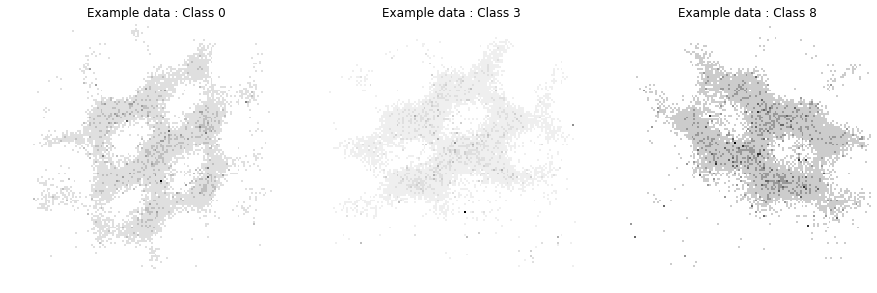

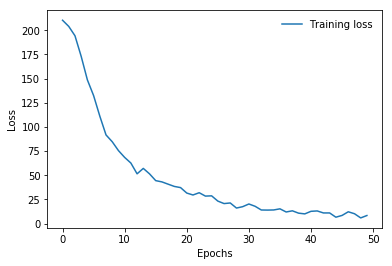

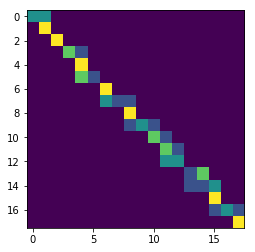

In [5]:
import os, json, pickle

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from collections import OrderedDict
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")
    
############################################ Input parameters ##############################################

num_epochs = 50
batch_size = 4
learning_rate = 0.0002

#################################################### Input #################################################

def remove_duplicates(data):
    for i in range(len(data)):
        for j in range(len(data[i])): 
            data[i][j] = list(OrderedDict.fromkeys(data[i][j]))
    return data

def count_spikes(data):
    for i in range(len(data)):
        for j in range(len(data[i])):
             data[i][j] = len(data[i][j])
    return data

class ImageDataset(Dataset):
    def __init__(self, features, labels, transform = None):
        super().__init__()
        self.features = features
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,index):
        return self.features[index], self.labels[index]
    
# Data directory
data_dir_name = 'collect_orientation_slide'
home_dir = os.path.join(os.environ['DATAPATH'], 'TacTip_NM', 'edgeTap_Dobot')
data_dir = os.path.join(home_dir, data_dir_name)
fig_save_dir = os.path.join(os.environ['PAPERPATH'],'2020_SNNs','figures', data_dir_name)
if not os.path.exists(fig_save_dir):
  os.mkdir(fig_save_dir)

# Load metadata
with open(data_dir + "/meta.json", "r") as read_file:
  meta = json.load(read_file)

# num_classes = meta['num_num_classes']
# num_trials = meta['num_trials']
num_classes = 18
num_trials = 20

train_trials = int(4/5*num_trials)
test_trials = int(1/5*num_trials)

train_dataset = []
test_dataset = []
train_labels = []
test_labels = []

print('Loading data... ' + str(num_classes)+' num_classes - '+str(num_trials)+' trials')

for class_idx in range(num_classes):
    for trial_idx in range(num_trials):

        # Load data
        filename = os.path.join(data_dir, 'data_pose_' + str(class_idx) + '_trial_' + str(trial_idx)+'.pickle')
        infile = open(filename,'rb')
        data = pickle.load(infile)       
        infile.close()
        data = remove_duplicates(data)
        data = count_spikes(data)
        if trial_idx < train_trials:
            train_dataset.append(data)
            train_labels.append(class_idx)
        else:
            test_dataset.append(data)
            test_labels.append(class_idx)

# Here we load the Dataset
print('Creating train/test split: '+str(train_trials)+' training trials - '+str(test_trials)+' test trials - ')

x_train = torch.tensor(train_dataset, device=device, dtype=dtype)
x_train = x_train.unsqueeze(1)
x_test = torch.tensor(test_dataset, device=device, dtype=dtype)
x_test = x_test.unsqueeze(1)

y_train = torch.tensor(train_labels, device=device, dtype=torch.long)
y_test  = torch.tensor(test_labels, device=device, dtype=torch.long)

train_data = ImageDataset(x_train, y_train)
test_data = ImageDataset(x_test, y_test)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2) 

# Here we plot one of the raw data points as an example

plt.figure(0,figsize=(15,10))
plt.subplot(131)
data_id = 0
plt.title('Example data : Class ' + str(train_labels[data_id]))
plt.imshow(x_train[data_id].reshape(128,128), cmap=plt.cm.gray_r)
plt.axis("off")
plt.subplot(132)
data_id = num_trials*3
plt.title('Example data : Class ' + str(train_labels[data_id]))
plt.imshow(x_train[data_id].reshape(128,128), cmap=plt.cm.gray_r)
plt.axis("off")
plt.subplot(133)
data_id = num_trials*7
plt.title('Example data : Class ' + str(train_labels[data_id]))
plt.imshow(x_train[data_id].reshape(128,128), cmap=plt.cm.gray_r)
plt.axis("off")
        
################################################### Network ##################################################


class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(720, 1024)
        self.fc2 = nn.Linear(1024, 18)

    def forward(self, x):
        x = F.max_pool2d(x,4)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x
    
net = Net()
model = Net().to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

print("init done")

################################################### Train network ###########################################

printing_interval = 100
train_losses = []

for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
#         print('labels ' + str(labels))
#         print('outputs ' + str(outputs))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss
        # calculate loss
#         if epoch*i % printing_interval == printing_interval-1:    # print every 100 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / printing_interval))
#             running_loss = 0.0
    train_losses.append(running_loss)
    print('Epoch:'+str(epoch)+' Loss: ' + str(running_loss))

plt.figure()
plt.plot(train_losses, label='Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

print('Finished Training')

###################################################### Testing ##############################################

# test-the-model
print('Testing')

class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
predicted_classes = []
actual_classes = []

model.eval()  # it-disables-dropout

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_classes.extend(predicted)
        actual_classes.extend(labels)
        total += labels.size(0)
#         correct += (predicted == labels).sum().item()
        correct = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
    accuracy = round(100 * sum(class_correct) / sum(class_total),2)
    print('Test Accuracy of the model:' + str(accuracy) + ' %')

predicted_classes = [int(i) for i in predicted_classes]
actual_classes = [int(i) for i in actual_classes]

class_errors = [abs(x1 - x2) for (x1, x2) in zip(predicted_classes, actual_classes)]
angle_error = round(10 * sum(class_errors) / len(class_errors),2)
print('Average angle error during testing: ' +  str(angle_error) +' degrees')

labels = range(num_classes)
cm = confusion_matrix(actual_classes, predicted_classes)
# print(cm)
plt.figure()
plt.imshow(cm)
                                              
###################################################### Results ##############################################

                                              
                                              

In [1]:
a = [1,2,3]
m = min(a)
print(m)

1
